In [1]:
import torch 
from torch import nn, Tensor

import matplotlib.pyplot as plt 

[]

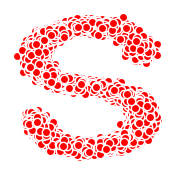

In [2]:
from sklearn.datasets import make_s_curve

# 创建一个数据集, 这个数据集在二维空间中呈现 S 型分布
samples, _ = make_s_curve(10**4, noise=0.1)
samples = samples[:, [0, 2]] / 10.0  # [n_samples, n_features]
samples = torch.from_numpy(samples).float()

# 画出这个概率分布的图片
plt.figure(figsize=(2, 2))
plt.scatter(samples.T[0], samples.T[1], color="red", edgecolors="white")
plt.axis("off")

plt.plot()

In [3]:
# ## Hyper Parameters

# 扩散的总步数, 在 DDPM 中是 1000 步, 这里我们设置成 100 步
NUM_STEPS = 100
# 每一步的扩散率, 这是不是按照线性变换设置的, 是一个奇怪的 scheduler, 但是是在逐渐变大, 最小是 2.23e-5, 最大是 4.99e-3
BETA_ARRAY = torch.sigmoid(torch.linspace(-6, 6, NUM_STEPS)) * (0.5e-2 - 1e-5) + 1e-5
# alpha_bar 不属于超参数, 但是后面用的比较多, 这里就先计算一下, 其是在慢慢变小的
ALPHA_BAR_ARRAY = torch.cumprod(1 - BETA_ARRAY, dim=0)

In [4]:
def forward_func_v1(x_prev: Tensor, t: int):
    ## 迭代方式实现扩散过程, 参考公式 (1)

    # x_prev: [n_samples, n_features]
    noise = torch.randn_like(x_prev)
    beta_t = BETA_ARRAY[t - 1]
    return torch.sqrt(1 - beta_t) * x_prev + torch.sqrt(beta_t) * noise

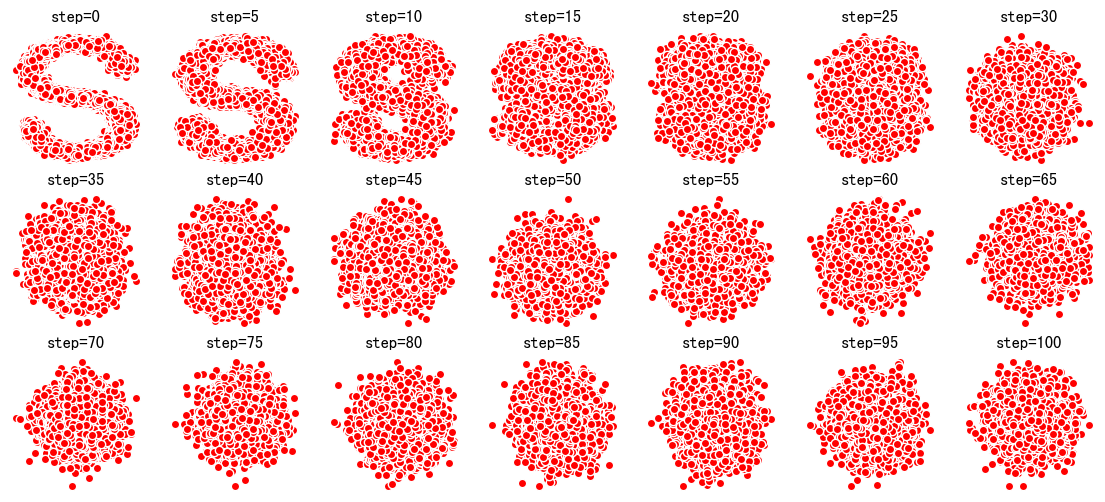

In [5]:
_, ax = plt.subplots(3, 7, figsize=(14, 6))
plt.rc("text", color="blue")

for t in range(0, NUM_STEPS + 1):
    
    if t == 0:
        cur_samples = samples
    else:
        cur_samples = forward_func_v1(cur_samples, t)
    
    if t % 5 == 0:
        item_idx = t // 5
        row_idx = item_idx // 7
        col_idx = item_idx % 7
        ax[row_idx, col_idx].scatter(cur_samples.T[0], cur_samples.T[1], color="red", edgecolors="white")
        ax[row_idx, col_idx].set_axis_off()
        ax[row_idx, col_idx].set_title(f"step={t}")


In [6]:
def forward_func_v2(x_0: Tensor, t: int):
    ## 非迭代方式实现扩散过程, 参考公式 (3)

    # x_0: [n_samples, n_features]
    noise = torch.randn_like(x_0)
    alpha_bar_t = ALPHA_BAR_ARRAY[t - 1]
    return torch.sqrt(alpha_bar_t) * x_0 + torch.sqrt(1 - alpha_bar_t) * noise

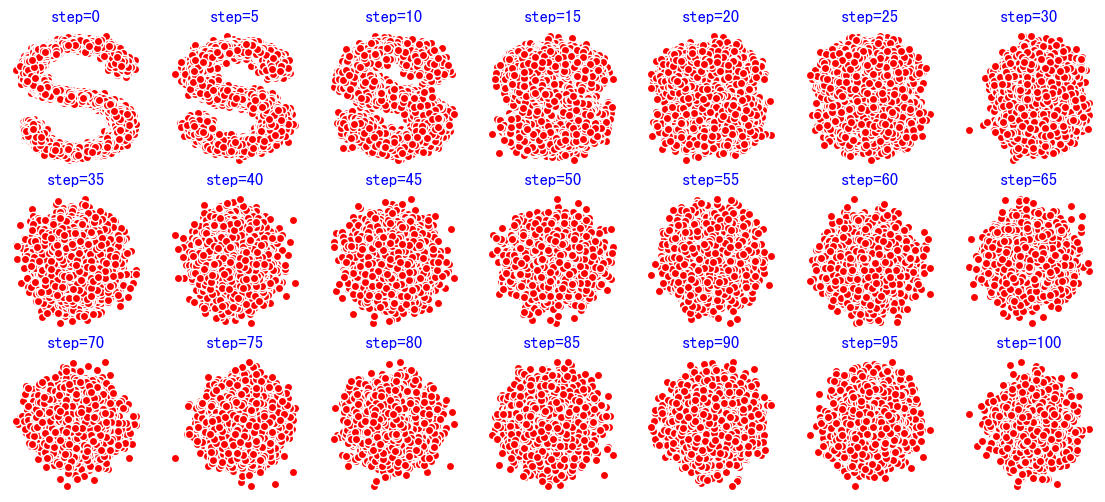

In [7]:
_, ax = plt.subplots(3, 7, figsize=(14, 6))
plt.rc("text", color="blue")

for item_idx in range(0, 21):
    
    if item_idx == 0:
        cur_samples = samples
    else:
        cur_samples = forward_func_v2(samples, item_idx * 5)

    row_idx = item_idx // 7
    col_idx = item_idx % 7
    ax[row_idx, col_idx].scatter(cur_samples.T[0], cur_samples.T[1], color="red", edgecolors="white")
    ax[row_idx, col_idx].set_axis_off()
    ax[row_idx, col_idx].set_title(f"step={item_idx * 5}")

In [8]:
class Block(nn.Module):
    
    def __init__(self, in_features: int, hidden_size: int):
        super().__init__()
        self.embed = nn.Embedding(NUM_STEPS, hidden_size)
        self.linear = nn.Linear(in_features, hidden_size)
    
    def forward(self, x, t):
        return torch.relu(self.linear(x) + self.embed(t))


class NoisePredictor(nn.Module):
    
    def __init__(self, hidden_size: int = 128):
        super().__init__()
        
        self.blocks = nn.ModuleList([
            Block(2, hidden_size), 
            Block(hidden_size, hidden_size),
            Block(hidden_size, hidden_size)
        ])
        
        self.linear = nn.Linear(hidden_size, 2)
    
    def forward(self, x, t):
        for block in self.blocks:
            x = block(x, t)

        return self.linear(x)

In [20]:
from torch.utils.data import DataLoader
from torch.optim import Adam

from tqdm import tqdm

NUM_EPOCHES = 4000

dataloader = DataLoader(samples, batch_size=128, shuffle=True)

noise_predictor = NoisePredictor(128)

optimizer = Adam(noise_predictor.parameters(), lr=1e-3)

loss_list = []

for _ in tqdm(range(NUM_EPOCHES)):
    for _, x_0 in enumerate(dataloader):
        x_0: Tensor  # [batch_size, n_features]

        # 采样 t
        batch_size = x_0.size(0)
        t = torch.randint(low=0, high=NUM_STEPS, size=(batch_size // 2, ))
        t = torch.cat([t, NUM_STEPS - 1 - t], dim=0)
        t = torch.unsqueeze(t, -1)  # [batch_size, 1]
        
        # 采样 noise
        noise = torch.randn_like(x_0)
        
        # 计算 x_t
        alpha_bar = ALPHA_BAR_ARRAY[t]
        x_t = torch.sqrt(alpha_bar) * x_0 + torch.sqrt(1 - alpha_bar) * noise
        
        # 计算 loss
        noise_hat = noise_predictor(x_t, t.squeeze(-1))
        loss = (noise_hat - noise).square().mean()
        
        # 反向传播
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(noise_predictor.parameters(), 1.)
        optimizer.step()
    
    loss_list.append(round(loss.item(), 4))

100%|██████████| 4000/4000 [29:51<00:00,  2.23it/s]


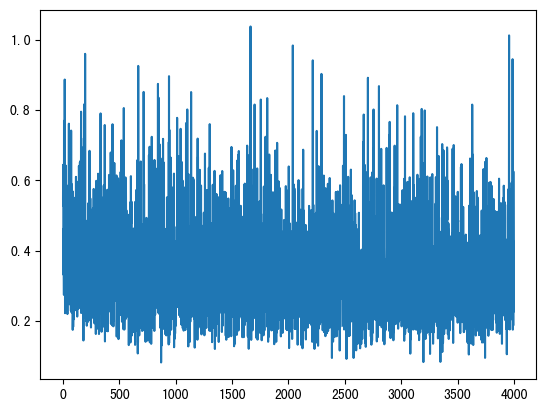

In [21]:
plt.plot(range(1, NUM_EPOCHES+1), loss_list)
plt.show()

In [22]:
min(loss_list)

0.0815

[]

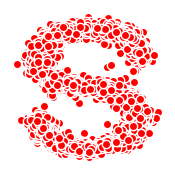

In [34]:
@torch.no_grad()
def inference(use_mean = False, use_one_step = False):
    x = torch.randn_like(samples)
    
    if use_one_step:
        noise_hat = noise_predictor(x, torch.tensor([NUM_STEPS - 1, ]))
        
        alpha_bar = ALPHA_BAR_ARRAY[NUM_STEPS - 1]
        
        return (x - torch.sqrt(1 - alpha_bar) * noise_hat) / torch.sqrt(alpha_bar)
    
    for t in range(NUM_STEPS-1, -1, -1):
        noise_hat = noise_predictor(x, torch.tensor([t]))
        
        w1 = 1. / torch.sqrt(1 - BETA_ARRAY[t])
        w2 = BETA_ARRAY[t] / torch.sqrt(1 - ALPHA_BAR_ARRAY[t])
        mean = w1 * (x - (w2 * noise_hat))
        
        if t > 1:
            noise = torch.randn_like(samples)
        else:
            noise = torch.zeros_like(samples)
        
        if use_mean:
            x = mean
        else:
            x = mean + torch.sqrt(BETA_ARRAY[t]) * noise
    
    return x

noise_predictor.eval()

# check = torch.randn_like(samples)  # 对照组
# check = inference(use_one_step=True)  # 效果不好
check = inference(use_mean=True)  # 形式单一
check = inference()  # 和 step5 的图片有点像

plt.figure(figsize=(2, 2))
plt.scatter(check.T[0], check.T[1], color="red", edgecolors="white")
plt.axis("off")

plt.plot()